# Obteniendo el OT entre dos distribuciones de caras

El objetivo de este notebook es el de obtener el OT entre las distribuciones de probabilidad generadas por dos dibujos de cara.

In [1]:
from quickdraw import QuickDrawDataGroup
import numpy as np
import matplotlib.pyplot as plt

import ot
import ot.plot

Empezamos obteniendo los datos tal como se hizo en el primer notebook.

In [2]:
# Definir el nombre del data set
DATASET_NAME = "face"

# Instanciar la clase
qd_data_group = QuickDrawDataGroup(DATASET_NAME, max_drawings=None)
print(f"{qd_data_group.drawing_count = }")

draw1 = qd_data_group.get_drawing(0)  # Obtener el primer dibujo
image1 = draw1.get_image()  # Obtener su imagen Pillow a través del método get_image
arr1 = np.asarray(image1)  # Transformarlo en arreglo
arr1.shape  # Obtener las dimensiones del arreglo

loading face drawings
load complete
qd_data_group.drawing_count = 161666


(255, 255, 3)

In [3]:
type(draw1.get_image())

PIL.Image.Image

face1.min() = 0.0,
face1.max() = 1.0,
face1.sum() = 2170.0

face1.min() = 0.0,
face1.max() = 0.0004608294930875576,
face1.sum() = 1.0


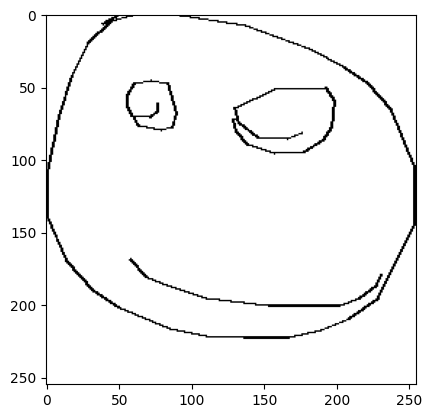

In [4]:
# Obtener una imagen del rango 0 a 1.
#  0 se asigna con el blanco.
face1 = 1 - (arr1[:, :, 2] / 255)
print(f"{face1.min() = },\n{face1.max() = },\n{face1.sum() = }\n")

# Transformar en distribución
face1 /= face1.sum()
print(f"{face1.min() = },\n{face1.max() = },\n{face1.sum() = }")

# Plotear
plt.imshow(face1, cmap="gray_r")

Dado que obtener la matriz de una cara a partir de los datos es algo recurrente que se hará, se diseñará una función que lo encapsule.

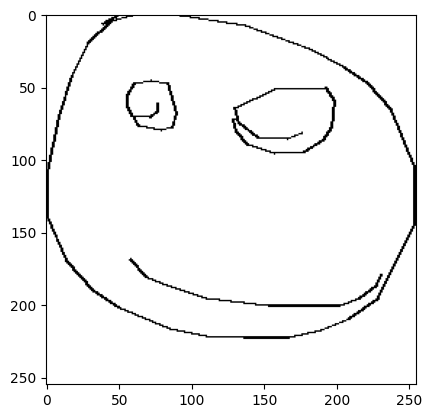

In [5]:
def draw_to_matrix(draw):
    image = draw.get_image()  # Obtener su imagen Pillow a través del método get_image
    arr = np.asarray(image)  # Transformarlo en arreglo

    # Obtener una imagen del rango 0 a 1.
    #  0 se asigna con el blanco.
    face_arr = 1 - (arr[:, :, 2] / 255)
    face_arr /= face_arr.sum()

    return face_arr

face1 = draw_to_matrix(draw1)
# Plotear
plt.imshow(face1, cmap="gray_r")

Ahora tenemos que obtener los puntos $x_s$ tales que sean las coordenadas en la matriz en los que no sean 0.

In [6]:
def get_points_non_zero(matrix: np.ndarray):
    assert len(matrix.shape) == 2, "Las dimensiones no calzan."

    matrix_ = np.rot90(matrix, 3)
    non_zero_coord = np.array(np.nonzero(matrix_)).T / (np.max(matrix.shape) - 1)
    return non_zero_coord

xs = get_points_non_zero(face1)
xs

array([[0.        , 0.4488189 ],
       [0.        , 0.45275591],
       [0.        , 0.45669291],
       ...,
       [1.        , 0.58267717],
       [1.        , 0.58661417],
       [1.        , 0.59055118]])

Hacemos una pequeña prueba con una matriz llena de 1's, que tiene dimensiones $(2, 3)$.

In [7]:
get_points_non_zero(np.ones((2, 3)))

array([[0. , 0. ],
       [0. , 0.5],
       [0.5, 0. ],
       [0.5, 0.5],
       [1. , 0. ],
       [1. , 0.5]])

Notamos que el mínimo es 0 y el máximo 1. Esto es bueno, pues buscábamos que las coordenadas estén en el cuadrado $[0, 1]^2$, manteniendo las proporciones.

Ahora obtenemos los puntos de la otra cara.

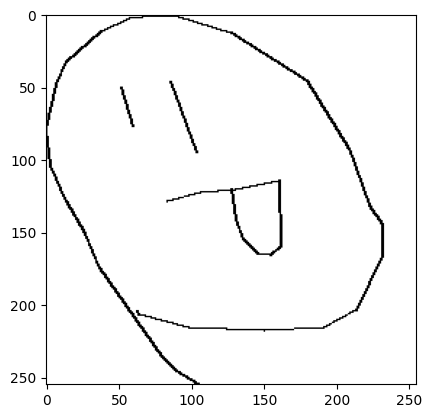

In [8]:
draw2 = qd_data_group.get_drawing(1)  # Obtener el segundo dibujo
face2 = draw_to_matrix(draw2)  # Transformarlo a matriz

# Plotear
plt.imshow(face2, cmap="gray_r")

Ahora obtenemos las coordenadas que sean distinto de 0

In [9]:
xt = get_points_non_zero(face2)
xt.shape

(1808, 2)

A partir de aquí nos inspiraremos en el segundo notebook.

Empezamos obteniendo los pesos tal que se cumpla que
\begin{align*}

In [10]:
# Obtener el número de puntos de ambas caras
n, m = len(xs), len(xt)

a, b = np.ones((n,)) / n, np.ones((m,)) / m  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)

In [11]:
M.shape

(2170, 1808)

Text(0.5, 1.0, 'Cost matrix M')

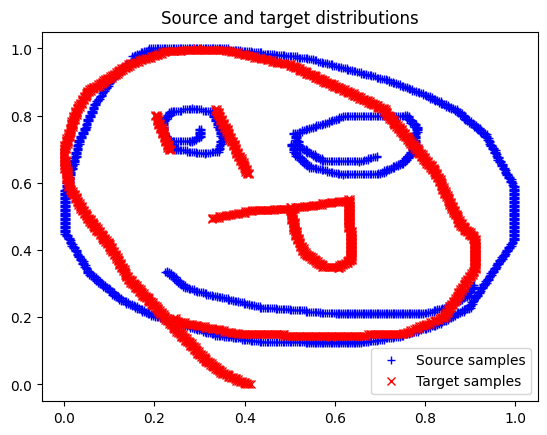

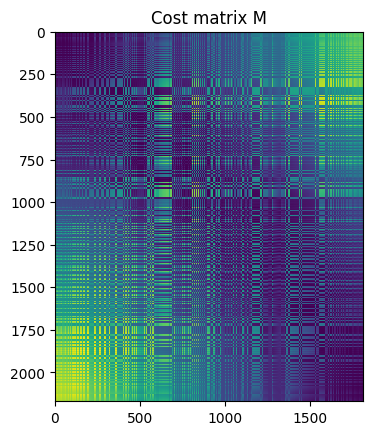

In [12]:
plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('Source and target distributions')

plt.figure(2)
plt.imshow(M, interpolation='nearest')
plt.title('Cost matrix M')

Ahora resolvemos el problema de transporte óptimo

CPU times: total: 16.7 s
Wall time: 6.06 s


Text(0.5, 1.0, 'OT matrix with samples')

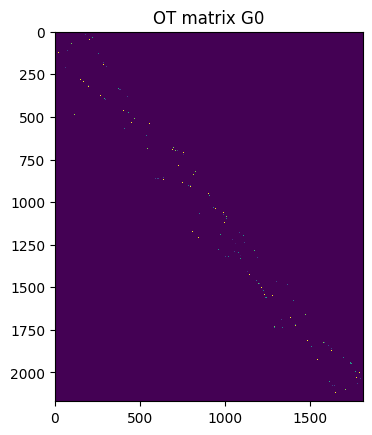

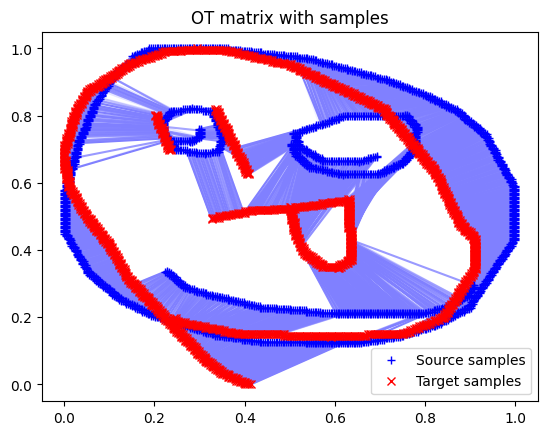

In [13]:
%%time
G0 = ot.emd(a, b, M, numThreads="max")

plt.figure(3)
plt.imshow(G0, interpolation='nearest')
plt.title('OT matrix G0')

plt.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('OT matrix with samples')

La primera vez que se corrió el notebook, se demoró 6 segundos en calcular el transporte óptimo. Veamos que sucede si